In [46]:
# Import required libraries.
import numpy as np

import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import imghdr
from IPython.display import Image, display
import requests

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import save_model

import matplotlib.pyplot as plt

In [2]:
TRAINING_DATASET_PATH = 'C:\\PRZEMEK\\Data_Analysis\\projects\\Python\\F1\\BolidVision\\data\\raw\\red_bull_mercedes_jpg'
TEST_DATASET_PATH = 'C:\\PRZEMEK\\Data_Analysis\\projects\\Python\\F1\\BolidVision\\data\\test_dataset'

# Data preparation

In [3]:
def create_datasets(train_path, test_path, batch_size=32, image_size=(224, 224), seed=42):
    """
    Create training, validation, and test datasets from image directories.

    Args:
        train_path (str): Path to the training dataset directory.
        test_path (str): Path to the test dataset directory.
        batch_size (int): Batch size for the datasets (default is 32).
        image_size (tuple): Image dimensions (height, width) (default is (224, 224)).
        seed (int): Seed for shuffling (default is 42).

    Returns:
        tuple: A tuple containing the training dataset, validation dataset, and test dataset.
    """
    
    # Create training dataset
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_path,
        label_mode='binary',  
        shuffle=True,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,  
        subset="training",
        seed=seed
    )

    # Create validation dataset
    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_path,
        label_mode='binary',
        shuffle=True,
        batch_size=batch_size,
        image_size=image_size,
        validation_split=0.2,
        subset="validation",
        seed=seed
    )

    # Create test dataset
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_path,
        label_mode='binary',
        shuffle=False,
        batch_size=batch_size,
        image_size=image_size
    )

    class_names = train_dataset.class_names  # Get the class names from the training dataset

    print("Classes:", class_names)

    return train_dataset, validation_dataset, test_dataset

In [4]:
train_dataset, validation_dataset, test_dataset = create_datasets(
    TRAINING_DATASET_PATH, TEST_DATASET_PATH)

Found 104 files belonging to 2 classes.
Using 84 files for training.
Found 104 files belonging to 2 classes.
Using 20 files for validation.
Found 22 files belonging to 2 classes.
Classes: ['mercedes', 'red_bull']


In [5]:
def display_images_from_dataset(dataset, num_images=6):
    """
    Displays a specified number of random images from a given dataset along with their class names.

    Args:
        dataset (tf.data.Dataset): The dataset to display images from.
        num_images (int, optional): The number of random images to display. Default is 6.
    """
    # Get class names from the dataset
    class_names = dataset.class_names
    
    # Get the first batch of data from the dataset
    for images, labels in dataset.take(1):
        # Choose num_images random indices of images
        num_total_images = images.shape[0]
        random_indices = np.random.choice(num_total_images, num_images, replace=False)

        # Select the images and labels corresponding to the random indices
        selected_images = tf.gather(images, random_indices)
        selected_labels = tf.gather(labels, random_indices)

        # Display the selected images with their class names
        plt.figure(figsize=(12, 8))
        for i in range(num_images):
            plt.subplot(2, 3, i + 1)
            plt.imshow(selected_images[i].numpy().astype("uint8"))
            label_index = int(selected_labels[i].numpy())
            plt.title(f"Class: {class_names[label_index]}")
            plt.axis("off")

        plt.show()

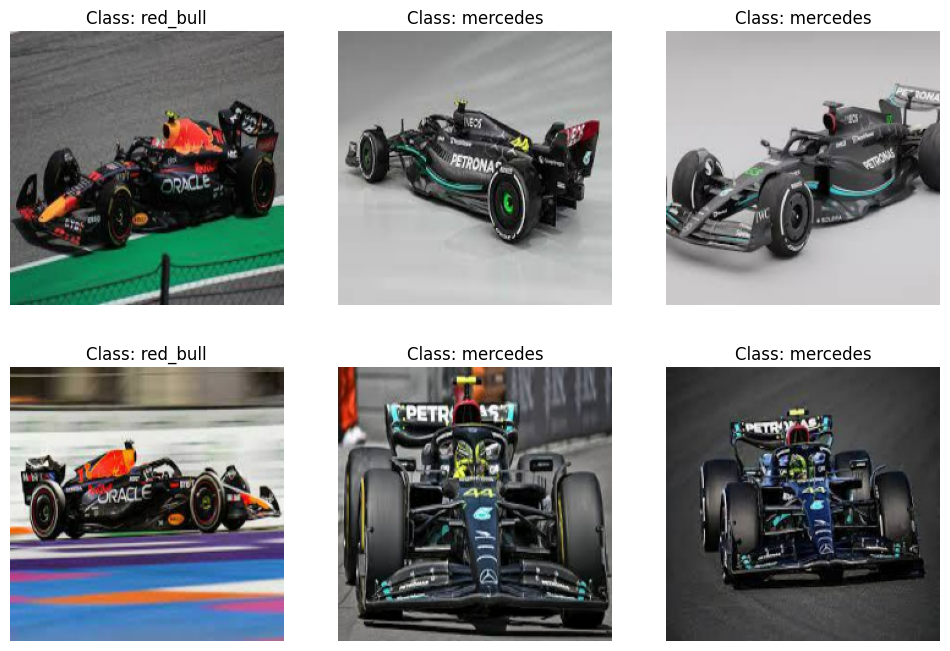

In [6]:
display_images_from_dataset(train_dataset)

# Model

In [7]:
def create_and_train_vgg19_model(train_dataset, validation_dataset, epochs=20):
    """
    Create and train a VGG19-based convolutional neural network model with data augmentation.

    Parameters:
    train_dataset (tf.data.Dataset): The training dataset.
    validation_dataset (tf.data.Dataset): The validation dataset.
    epochs (int): Number of training epochs (default is 20).

    Returns:
    model (tf.keras.Model): The trained VGG19-based model.
    history (tf.keras.callbacks.History): Training history.
    """

    # Base VGG model
    base_vgg_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_vgg_model.trainable = False

    # Data augmentation layer
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.4),
        tf.keras.layers.RandomContrast(0.4),
        tf.keras.layers.RandomBrightness(0.4)
    ])

    # Definition of a CNN model with data augmentation based on VGG architecture
    model = Sequential([
        data_augmentation,
        base_vgg_model,
        Conv2D(512, (3, 3), activation='relu'),
        MaxPool2D(2, 2),
        Flatten(),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.3),
        Dense(512, activation='relu', kernel_initializer='he_normal'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model using the Adam optimizer, binary_crossentropy loss function, and accuracy metric.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping with patience of 4 epochs
    earlystop = EarlyStopping(patience=4)

    # Define learning rate reduction callback to monitor validation loss, reduce by a factor of 0.2, and set a minimum learning rate
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=4,
                                                verbose=2,
                                                factor=0.2,
                                                min_lr=0.0001)

    # Combine both callbacks into a list
    callbacks = [earlystop, learning_rate_reduction]

    # Train the model using the training dataset, validate on the validation dataset,
    # run for the specified number of epochs, display training progress, and apply defined callbacks.
    history = model.fit(train_dataset, validation_data=validation_dataset,
                        epochs=epochs, verbose=1, callbacks=callbacks)

    return model, history

In [8]:
model, history = create_and_train_vgg19_model(train_dataset, validation_dataset)

Epoch 1/20
3/3 [==============================] - 19s 6s/step - loss: 24.1538 - accuracy: 0.5357 - val_loss: 50.8151 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 16s 6s/step - loss: 16.3062 - accuracy: 0.6071 - val_loss: 29.1117 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 16s 6s/step - loss: 14.0489 - accuracy: 0.5357 - val_loss: 10.1486 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 16s 6s/step - loss: 7.1479 - accuracy: 0.5714 - val_loss: 3.2903 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 16s 6s/step - loss: 2.9428 - accuracy: 0.5952 - val_loss: 0.5173 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 6/20
3/3 [==============================] - 16s 5s/step - loss: 2.2865 - accuracy: 0.6310 - val_loss: 0.4758 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 7/20
3/3 [==============================] - 16s 6s/step - loss: 1.4869 - accuracy:

In [10]:
model.save('C:\\PRZEMEK\\Data_Analysis\\projects\\Python\\F1\\BolidVision\\models\\model_1.keras')

In [11]:
def plot_history(history):
    """
    Plot training and validation loss and accuracy curves.

    Args:
        history (keras.callbacks.History): The training history obtained from a Keras model.fit() call.

    Returns:
        None
    """

    # Plot the Loss Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['loss'], 'o--', linewidth=3.0, label='Training loss')
    plt.plot(history.history['val_loss'], 'p--', linewidth=3.0, label='Validation Loss')
    plt.legend(fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Loss Curves', fontsize=14)

    # Plot the Accuracy Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['accuracy'], 'o--', linewidth=3.0, label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], 'p--', linewidth=3.0, label='Validation Accuracy')
    plt.legend(fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Accuracy Curves', fontsize=14)

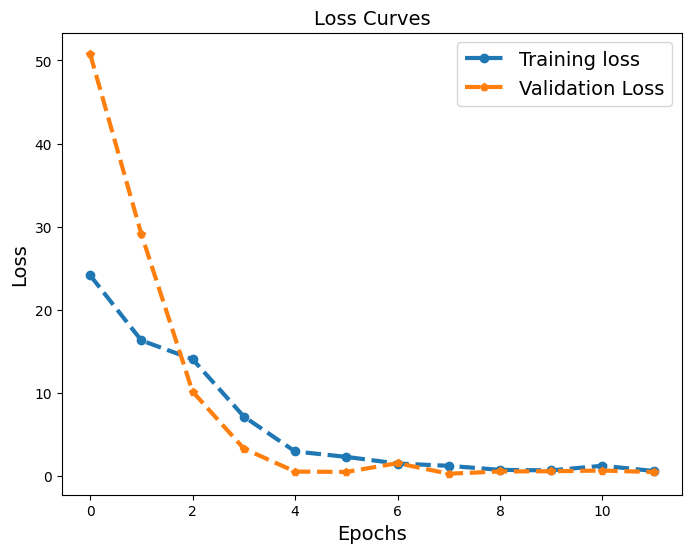

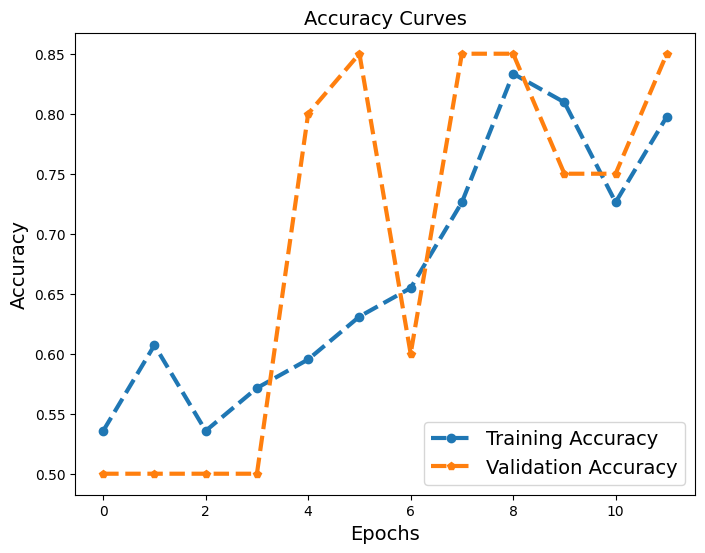

In [12]:
plot_history(history)

# Classification report

In [13]:
def get_predictions(model, dataset):
    """
    Get true labels and predicted labels for a given model and dataset.

    Args:
        model (tf.keras.Model): The trained model for making predictions.
        dataset (tf.data.Dataset): The dataset containing test samples and labels.

    Returns:
        tuple: A tuple containing two lists - true_labels and predicted_labels.
               true_labels: List of true labels from the dataset.
               predicted_labels: List of predicted labels generated by the model.
    """
    # Initialize empty lists for true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset to obtain true labels and predictions
    for batch in dataset:
        images, labels = batch
        predictions = model.predict(images)
        
        # Add true labels to the list
        true_labels.extend(labels.numpy())
        
        # Add predicted labels to the list
        predicted_labels.extend(np.round(predictions).flatten())

    return true_labels, predicted_labels

In [14]:
true_labels, predictions = get_predictions(model, test_dataset)

1/1 [==============================] - 3s 3s/step


In [15]:
report = classification_report(true_labels, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91        11
         1.0       0.91      0.91      0.91        11

    accuracy                           0.91        22
   macro avg       0.91      0.91      0.91        22
weighted avg       0.91      0.91      0.91        22



In [16]:
def plot_confusion_matrix(true_labels, predicted_labels, class_labels=None):
    """
    Plot a confusion matrix using true labels and predicted labels.

    Args:
        true_labels (list): List of true labels.
        predicted_labels (list): List of predicted labels.
        class_labels (list, optional): List of class labels. Default is None.

    Returns:
        None
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

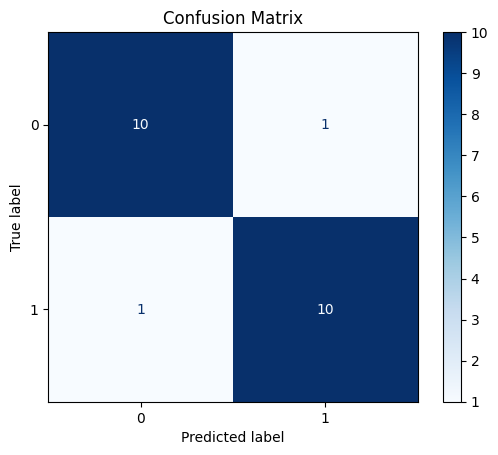

In [18]:
plot_confusion_matrix(true_labels, predictions)

In [ ]:
# Test

In [50]:
def display_and_save_img(image_url):
    try:
        img_name = os.path.basename(image_url)
        img_path = keras.utils.get_file(img_name, image_url)
        display(Image(img_path))
        return img_path
    except requests.exceptions.HTTPError as e:
        print(f"HTTPError: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

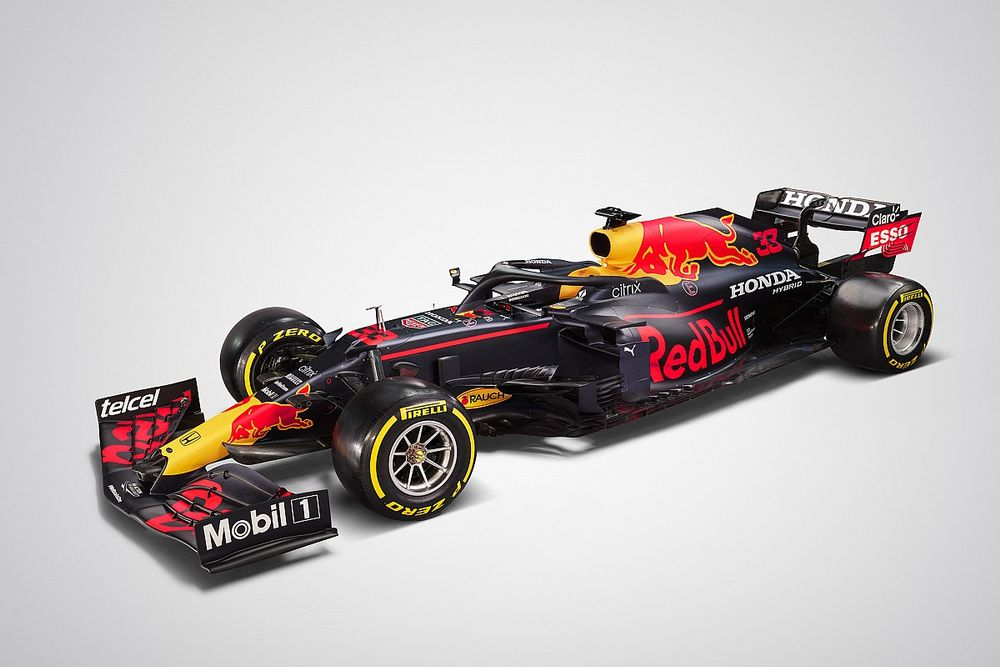

In [217]:
img_path = display_and_save_img("https://cdn-2.motorsport.com/images/amp/2d1Wrw3Y/s1000/formula-1-red-bull-racing-laun-2.jpg")

In [191]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [204]:
def predict(img_path, model, img_size=(224, 224)):
    """
    Predicts the class label and maximum probability score for an input image using a pre-trained model.

    Args:
        img_path (str): The file path to the input image.
        model (keras.Model): The pre-trained neural network model for image classification.
        img_size (tuple): The target size for resizing the input image (default is (224, 224)).

    Returns:
        None: Prints the predicted class label and maximum probability score.
    """
    # Preprocess the input image
    preprocess_input = keras.applications.vgg16.preprocess_input
    img_array = preprocess_input(get_img_array(img_path, img_size))
    
    # Make predictions using the model
    preds = model.predict(img_array)
    
    # Find the predicted class label
    predicted_class = np.argmax(preds, axis=1)
    
    # Assuming 'train_dataset' is defined elsewhere, get class names
    class_names = train_dataset.class_names
    
    # Get the predicted label and probability score for the top prediction
    predicted_label = class_names[predicted_class[0]]
    probability_score = preds[0][predicted_class[0]]
    
    # Print the predicted class label and maximum probability score
    print(f"Predicted Class: {predicted_label}")
    print(f"Probability Score: {probability_score:.4f}")

In [212]:
def display_and_predict_img(image_url, model, train_dataset, img_size=(224, 224)):
    """
    Display an image from a given URL, make predictions using a pre-trained model,
    and print the predicted class label and probability score.

    Args:
        image_url (str): URL of the image to be displayed and predicted.
        model (keras.Model): A pre-trained deep learning model for image classification.
        train_dataset: The dataset containing class names for label mapping.
        img_size (tuple): A tuple specifying the target image size (width, height).

    Raises:
        requests.exceptions.HTTPError: If there's an HTTP error while fetching the image.
        Exception: If an error occurs during the prediction process.

    Returns:
        None
    """
    try:
        # Extract the image name from the URL and create a local path to download it
        img_name = os.path.basename(image_url)
        img_path = keras.utils.get_file(img_name, image_url)

        # Display the downloaded image
        display(Image(img_path))

        # Preprocess the image for model input
        preprocess_input = keras.applications.vgg16.preprocess_input
        img_array = preprocess_input(get_img_array(img_path, img_size))

        # Make predictions using the provided model
        preds = model.predict(img_array)

        # Find the predicted class index and class name
        predicted_class = np.argmax(preds, axis=1)
        class_names = train_dataset.class_names
        predicted_label = class_names[predicted_class[0]]

        # Get the probability score for the predicted class
        probability_score = preds[0][predicted_class[0]]

        # Print the prediction results
        print(f"Predicted Label: {predicted_label}")
        print(f"Probability Score: {probability_score:.4f}")

    except requests.exceptions.HTTPError as e:
        print(f"HTTPError: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [214]:
image_url ='https://cdn-9.motorsport.com/images/mgl/YN19B7j2/s8/red-bull-racing-rb19-1.jpg'

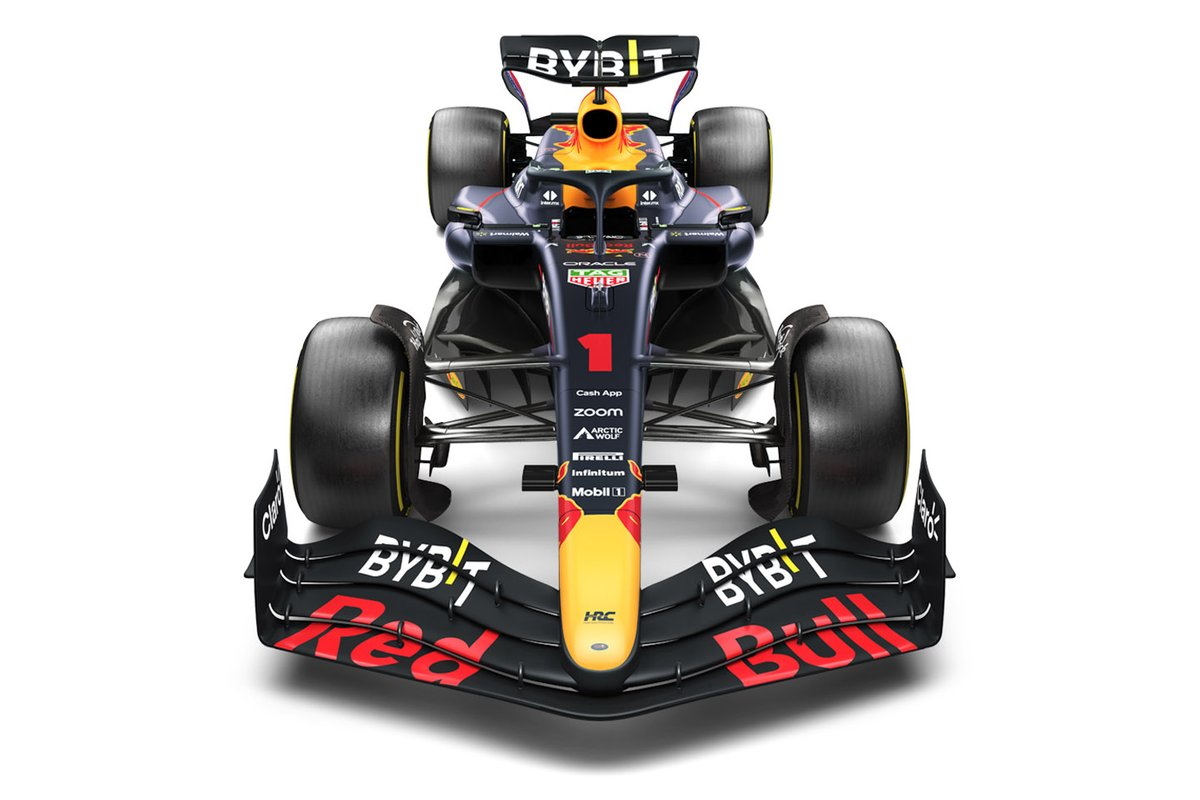

1/1 [==============================] - 0s 144ms/step
Predicted Label: mercedes
Probability Score: 0.9987


In [215]:
display_and_predict_img(image_url, model, train_dataset)


# Grad-CAM class activation visualization

In [225]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 512)         2359808   
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                      

In [276]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate a Grad-CAM heatmap for a given input image.

    Args:
        img_array (numpy.ndarray): The input image as a NumPy array.
        model (tensorflow.keras.Model): The trained model for which the Grad-CAM heatmap is generated.
        last_conv_layer_name (str): The name of the last convolutional layer in the model.
        pred_index (int, optional): The index of the class for which the heatmap should be generated.
                                    If not provided, the class with the highest predicted probability will be used.

    Returns:
        numpy.ndarray: The Grad-CAM heatmap as a NumPy array.

    This function generates a Grad-CAM (Gradient-weighted Class Activation Map) heatmap for an input image using a
    pre-trained model. It highlights the regions in the input image that are most relevant to the predicted class.

    The algorithm involves the following steps:
    1. Create a model that maps the input image to the activations of the last convolutional layer as well as the output predictions.
    2. Compute the gradient of the top predicted class (or the specified class) with respect to the activations of the last convolutional layer.
    3. Calculate the mean intensity of the gradient over each feature map channel.
    4. Multiply each channel in the feature map array by its importance with regard to the top predicted class.
    5. Sum all the channels to obtain the heatmap class activation.
    6. Normalize the heatmap between 0 and 1 for visualization.

    Example:
    ```
    # Load your model and input image
    model = keras.applications.VGG16(weights='imagenet', include_top=True)
    img_array = preprocess_input(load_image('your_image.jpg'))

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, 'block5_conv3')

    # Visualize the heatmap on the original image
    superimposed_img = superimpose_heatmap(img_array, heatmap)

    # Display or save the superimposed image
    plt.imshow(superimposed_img)
    plt.show()
    ```

    For detailed usage and visualization, you can use the `superimpose_heatmap` function to overlay the heatmap on the original image.
    """
    # Create a model that maps the input image to the activations of the last convolutional layer and predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image with respect to the last convolutional layer activations
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Calculate the gradient of the output neuron (top predicted or chosen) with respect to the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Calculate the mean intensity of the gradient over each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by its importance and sum to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [277]:

def generate_and_display_heatmap(img_path, model, last_conv_layer_name, img_size=(224, 224)):
    """
    Generate and display the class activation heatmap for an image.

    Args:
        img_path (str): Path to the image for which the heatmap should be generated.
        model (keras.Model): The neural network model.
        last_conv_layer_name (str): Name of the last convolutional layer in the model.
        img_size (tuple, optional): Size to which the original image should be resized. Defaults to (224, 224).

    Returns:
        heatmap (numpy.ndarray): The class activation heatmap.
    """
    preprocess_input = keras.applications.vgg16.preprocess_input
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Display heatmap
    plt.matshow(heatmap)
    plt.show()

    return heatmap

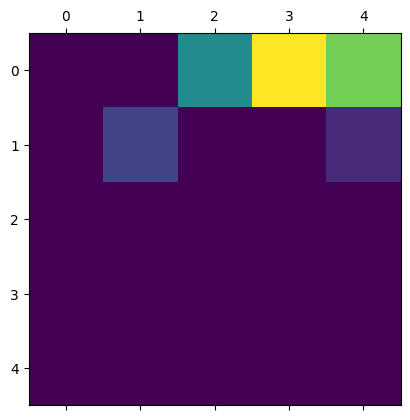

In [278]:
heatmap = generate_and_display_heatmap(img_path, model, 'conv2d')

In [279]:
import matplotlib.cm as mpl_cm
import matplotlib.pyplot as plt

def save_and_display_gradcam(img_path, model, heatmap, last_conv_layer_name, cam_path="cam.jpg", alpha=0.4, img_size=(224, 224)):
    """
    Generate and save a Grad CAM (Gradient-weighted Class Activation Mapping) visualization for an image and display it.

    Args:
        img_path (str): Path to the original image.
        model (keras.Model): The neural network model to be used for Grad CAM visualization.
        heatmap: Heatmap generated using Grad CAM.
        last_conv_layer_name (str): Name of the last convolutional layer in the model.
        cam_path (str, optional): Path to save the Grad CAM image. Defaults to "cam.jpg".
        alpha (float, optional): Blending factor for superimposing the heatmap on the original image. Defaults to 0.4.
        img_size (tuple, optional): Size to which the original image should be resized. Defaults to (224, 224).

    Returns:
        None
    """
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    
    # Heatmap
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    model.layers[-1].activation = None
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use the "plasma" colormap to colorize heatmap
    jet = mpl_cm.get_cmap("plasma")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

C:\Users\Przemek\AppData\Local\Temp\ipykernel_37440\3681806813.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl_cm.get_cmap("plasma")


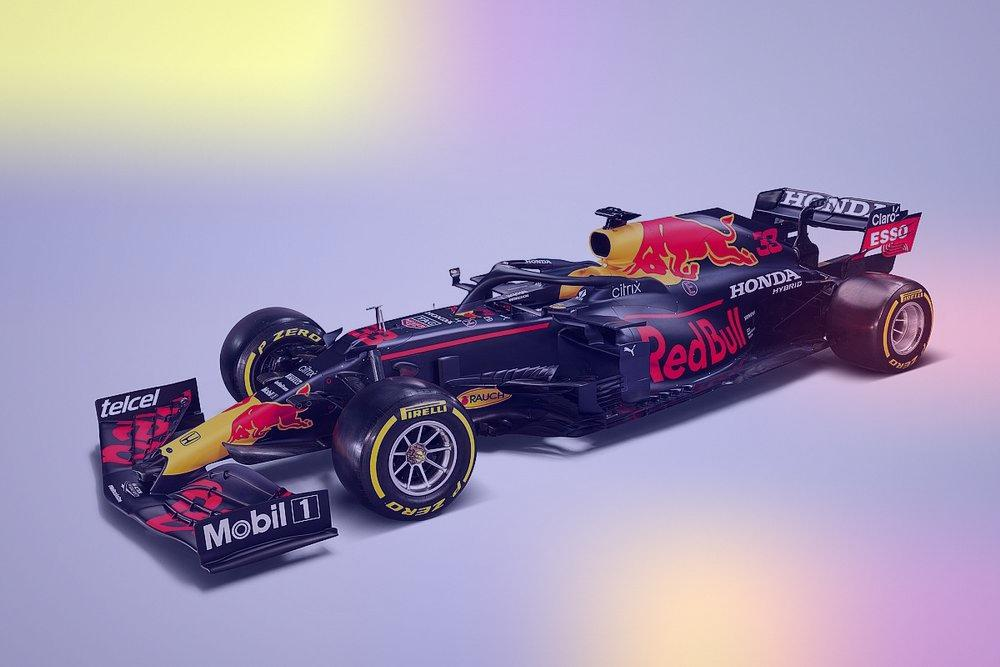

In [275]:
save_and_display_gradcam(img_path, model, heatmap, 'conv2d')